# New York Times News Summarization
Sirut Buasai, sbausai2@wpi.edu <br>
Jason Dykstra, jpdykstra@wpi.edu <br>
Adam Yang ayang@wpi.edu
## Libraries

In [27]:
# Data Processing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import csv

# Text Processing
import nltk
import re
import spacy
from nltk.corpus import stopwords
from nltk import pos_tag_sents

# Model Building
import tensorflow as tf
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

# Metrics
from sacrebleu import sentence_bleu
from rouge import Rouge

# Google Colab
# from google.colab import drive, files
# drive.mount('/content/gdrive')

# Downloads
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
NER = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sirutbuasai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sirutbuasai/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Global Variables

In [28]:
MAX_ABSTRACT_LEN = 30
MAX_TITLE_LEN = 12
LATENT_DIMENSION = 300 
EMBEDDING_DIMENSION = 100 
EPOCH = 10
BATCH_SIZE = 128
DATA_SET_RATIO = 0.8
MODEL_CONDITION = "cleaned_abstract"

## Data Pre-processing
### Initial Data Inspection

In [29]:
# download and make initial inspection of the dataset
# raw_data_path = '/content/gdrive/My Drive/Fourth Year/Natural Language Processing/Final Project/NYT_Dataset.csv'
raw_data_path = 'NYT_Dataset.csv'
raw_data = pd.read_csv(raw_data_path)
raw_data = raw_data[:int(DATA_SET_RATIO*len(raw_data))]
print(f'dataframe shape: {raw_data.shape}')
raw_data

dataframe shape: (106, 7)


,Unnamed: 0,ID,title,topic,abstract,Date,keywords
0,0,nyt://article/178801fe-4679-5f12-985f-8344a86e...,"In Reversal, Pakistan Welcomes Outside Help Wi...",Foreign,Pakistan’s ambassador to the U.S. said his gov...,2008-01-01 05:00:00+00:00,['Assassinations and Attempted Assassinations'...
1,1,nyt://article/21acedcb-a7f6-5131-99cf-d3a47e33...,Fighting Intensifies After Election in Kenya,Foreign,"Kenya sank deeper into trouble, with a curfew ...",2008-01-01 05:00:00+00:00,"['Kenya', 'Demonstrations and Riots', 'Odinga,..."
2,2,nyt://article/357b5429-a9f8-5d33-a5eb-c013a201...,Israel: Olmert Curbs Settlements,Foreign,Prime Minister Ehud Olmert has sent a letter t...,2008-01-01 05:00:00+00:00,['West Bank']
3,3,nyt://article/619ca4ea-50e4-59e4-97bb-f206502c...,Gay Muslims Pack a Dance Floor of Their Own,Foreign,The monthly club night known as Gayhane is an ...,2008-01-01 05:00:00+00:00,"['Homosexuality', 'Islam', 'IMMIGRATION AND RE..."
4,4,nyt://article/73c49a5a-bcf1-5b8f-a15a-98d29003...,Iraqi Revelers Embrace the New Year,Foreign,"But even as partygoers embraced the New Year, ...",2008-01-01 05:00:00+00:00,"['ARMAMENT, DEFENSE AND MILITARY FORCES', 'Iraq']"
...,...,...,...,...,...,...,...
101,101,nyt://slideshow/dbf99825-09fb-5f03-bb04-da2d02...,Mortgages and Women,U.S.,The focus of conversation at hair salons in Ba...,2008-01-08 08:39:00+00:00,"['Mortgages', 'Baltimore (Md)']"
102,102,nyt://slideshow/4b7032f0-8c1a-5895-9654-c2ff26...,Voting in New Hampshire,U.S.,Primary voters streamed to the polls in New Ha...,2008-01-08 17:45:01+00:00,"['Presidential Election of 2008', 'PRIMARIES',..."
103,103,nyt://article/077f5a51-d939-58e0-8074-ea9974d1...,"At Gaza’s Edge, Israelis Fear Rockets’ Whine",Foreign,"Sderot, Israel, a working-class town less than...",2008-01-09 05:00:00+00:00,"['Palestinians', 'Israel', 'Gaza Strip', 'Bomb..."
104,104,nyt://article/09196e5e-98d3-5070-a235-c005b505...,"Jean-Claude Vrinat, Owner of Famed Paris Resta...",Foreign,"For more than three decades, Mr. Vrinat was th...",2008-01-09 05:00:00+00:00,"['Restaurants', 'France', 'Taillevent', 'Death..."


### Clean Data
#### Part of Speech Processing Function

In [30]:
# Parts-of-Speech processing to filter and keep certain POS words
def pos_processing(abstract_sentences):
  # split the sentence into tokens
  abstract_tokens = pd.Series(abstract_sentences.apply(lambda sentence: sentence.split()))

  # identify parts-of-speech; pos_tag requires list of tokens
  abstract_pos = pd.Series(pos_tag_sents(abstract_tokens))

  # filter non-desirable parts-of-speech
  nounsList = ['NN', 'NNS', 'NNP', 'NNPS'] # Nouns
  verbsList = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VPZ'] # Verbs
  adjList = ['JJ', 'JJR', 'JJS'] # Adjectives
  pos_list = nounsList + verbsList + adjList
  abstract_pos_filtered = abstract_pos.apply(lambda words: ' '.join([pair[0] for pair in words if pair[1] in pos_list]))

  return abstract_pos_filtered

#### NER Processing Function

In [31]:
# NER function to identify and embed NER tags
def ner_processing(abstract_sentences):
  # identify entities for each abstract
  abs_entities = pd.Series(abstract_sentences.apply(lambda sentence: NER(sentence)))

  # extract the original sentences, but now with split contractions and the entity type from NER
  original_sentence = pd.Series(abs_entities.apply(lambda entities: ' '.join([f"{token.orth_}<{token.ent_type_}>" if token.ent_type_ else f"{token.orth_}" for token in entities])))

  return original_sentence

#### Clean Text Function

In [32]:
# Main preprocessing function
def preprocess_data(df):
  # drop unnecessary columns
  unused_columns = ['Unnamed: 0', 'Date', 'ID']
  df.drop(unused_columns, axis=1, inplace=True, errors='ignore')

  # drop duplicates and nan rows
  df.drop_duplicates(subset=['abstract'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  df.dropna(axis=0, inplace=True)
  df.reset_index(drop=True, inplace=True)

  # convert texts to lowercase
  df['abstract'] = df['abstract'].str.lower()
  df['title'] = df['title'].str.lower()
  df['keywords'] = df['keywords'].str.lower()
  df['topic'] = df['topic'].str.lower()

  # strip special characters
  df['cleaned_title'] = df['title'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))
  df['cleaned_abstract'] = df['abstract'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))
  df['cleaned_keywords'] = df['keywords'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))
  df['cleaned_topic'] = df['topic'].apply(lambda text: re.sub("[^a-zA-Z0-9 ]+", '', text))

  # add keywords and topics
  df['cleaned_keywords'] = df['cleaned_keywords'].apply(lambda sentence: "".join(word for word in sentence))
  df['cleaned_abstract_keywords'] = df['cleaned_abstract'] + ' ' + df['cleaned_keywords'] + ' ' + df['topic']

  # convert string to list
  df['cleaned_title'] = df['cleaned_title'].apply(lambda text: text.split())
  df['cleaned_abstract'] = df['cleaned_abstract'].apply(lambda text: text.split())
  df['cleaned_abstract_keywords'] = df['cleaned_abstract_keywords'].apply(lambda text: text.split())

  # remove stopwords
  stop_words = stopwords.words('english')
  df['cleaned_title'] = df['cleaned_title'].apply(lambda sentence: [word for word in sentence if word not in (stop_words)])
  df['cleaned_abstract'] = df['cleaned_abstract'].apply(lambda sentence: [word for word in sentence if word not in (stop_words)])
  df['cleaned_abstract_keywords'] = df['cleaned_abstract_keywords'].apply(lambda sentence: [word for word in sentence if word not in (stop_words)])

  # convert list back to string
  df['cleaned_title'] = df['cleaned_title'].apply(lambda sentence: " ".join(word for word in sentence))
  df['cleaned_abstract'] = df['cleaned_abstract'].apply(lambda sentence: " ".join(word for word in sentence))
  df['cleaned_abstract_keywords'] = df['cleaned_abstract_keywords'].apply(lambda sentence: " ".join(word for word in sentence))

  # filter and keep noun, verbs, and adj words; requires string sentences
  df['cleaned_abstract_pos'] = pos_processing(df['cleaned_abstract'])
  df['cleaned_abstract_pos_keywords'] = pos_processing(df['cleaned_abstract_keywords'])

  # identify named-entities; NER requires string sentences
  df['cleaned_title'] = ner_processing(df['cleaned_title'])
  df['cleaned_abstract_pos_ner'] = ner_processing(df['cleaned_abstract_pos'])
  df['cleaned_abstract_pos_keywords_ner'] = ner_processing(df['cleaned_abstract_pos_keywords'])

  # add start and end tokens for title
  df['cleaned_title'] = df['cleaned_title'].apply(lambda text: 'sostok ' + text + ' eostok')

  # drop unnecessary columns
  unnecessary_columns = ['topic', 'keywords', 'cleaned_keywords', 'cleaned_topic', 'cleaned_abstract_keywords']
  df.drop(unnecessary_columns, axis=1, inplace=True, errors='ignore')

  # important columns are cleaned_title, cleaned_abstract, cleaned_abstract_pos_ner, cleaned_abstract_pos_keywords_ner
  return df

cleaned_data = preprocess_data(raw_data)

# Google Colab code
# cleaned_data = pd.read_csv("cleaned_data.csv")
# print(f'dataframe shape: {cleaned_data.shape}')

# save df to drive
# cleaned_data.to_pickle('/content/gdrive/My Drive/Fourth Year/Natural Language Processing/Final Project/NYT_preprocessed.pkl')

# load df from drive
# cleaned_data = pd.read_pickle('/content/gdrive/My Drive/Fourth Year/Natural Language Processing/Final Project/NYT_preprocessed.pkl')  

cleaned_data

,title,abstract,cleaned_title,cleaned_abstract,cleaned_abstract_pos,cleaned_abstract_pos_keywords,cleaned_abstract_pos_ner,cleaned_abstract_pos_keywords_ner
0,"in reversal, pakistan welcomes outside help wi...",pakistan’s ambassador to the u.s. said his gov...,sostok reversal pakistan<GPE> welcomes outside...,pakistans ambassador us said government would ...,pakistans ambassador said government endorse s...,pakistans ambassador said government endorse s...,pakistans<NORP> ambassador said government end...,pakistans<NORP> ambassador said government end...
1,fighting intensifies after election in kenya,"kenya sank deeper into trouble, with a curfew ...",sostok fighting intensifies election kenya<GPE...,kenya sank deeper trouble curfew imposed kisum...,kenya sank trouble curfew imposed kisumu count...,kenya sank trouble curfew imposed kisumu count...,kenya<PERSON> sank trouble curfew imposed kisu...,kenya<PERSON> sank trouble curfew imposed kisu...
2,israel: olmert curbs settlements,prime minister ehud olmert has sent a letter t...,sostok israel<GPE> olmert<PERSON> curbs settle...,prime minister ehud olmert sent letter defense...,prime minister ehud olmert sent letter defense...,prime minister ehud olmert sent letter defense...,prime minister ehud<PERSON> olmert<PERSON> sen...,prime minister ehud<PERSON> olmert<PERSON> sen...
3,gay muslims pack a dance floor of their own,the monthly club night known as gayhane is an ...,sostok gay muslims<NORP> pack dance floor eostok,monthly club night known gayhane alltoorare op...,club night known gayhane alltoorare opportunit...,club night known gayhane alltoorare opportunit...,club night known gayhane alltoorare opportunit...,club night known gayhane alltoorare opportunit...
4,iraqi revelers embrace the new year,"but even as partygoers embraced the new year, ...",sostok iraqi<NORP> revelers embrace new<DATE> ...,even partygoers embraced new year surge attack...,partygoers embraced new year surge attacks mon...,partygoers embraced new year surge attacks mon...,partygoers embraced new year<DATE> surge attac...,partygoers embraced new year<DATE> surge attac...
...,...,...,...,...,...,...,...,...
101,mortgages and women,the focus of conversation at hair salons in ba...,sostok mortgages women eostok,focus conversation hair salons baltimore turne...,focus conversation hair salons baltimore turne...,focus conversation hair salons baltimore turne...,focus conversation hair salons baltimore turne...,focus conversation hair salons baltimore turne...
102,voting in new hampshire,primary voters streamed to the polls in new ha...,sostok voting new hampshire eostok,primary voters streamed polls new hampshire el...,primary voters streamed polls new hampshire el...,primary voters streamed polls new hampshire el...,primary voters streamed polls new hampshire el...,primary voters streamed polls new hampshire el...
103,"at gaza’s edge, israelis fear rockets’ whine","sderot, israel, a working-class town less than...",sostok gazas<PERSON> edge<PERSON> israelis<NOR...,sderot israel workingclass town less two miles...,sderot israel workingclass town miles hit rockets,sderot israel workingclass town miles hit rock...,sderot israel<GPE> workingclass town miles hit...,sderot israel<GPE> workingclass town miles hit...
104,"jean-claude vrinat, owner of famed paris resta...","for more than three decades, mr. vrinat was th...",sostok jeanclaude<PERSON> vrinat<PERSON> owner...,three decades mr vrinat owner taillevent resta...,decades mr vrinat owner taillevent restaurant ...,decades mr vrinat owner taillevent restaurant ...,decades<DATE> mr vrinat owner taillevent resta...,decades<DATE> mr vrinat owner taillevent resta...


In [33]:
# print first five rows to check results
for i in range(5):
  print("Abstract:\n\t", cleaned_data['abstract'][i])
  print("Title:\n\t", cleaned_data['title'][i])
  print("\n")
  print("Cleaned Abstract:\n\t", cleaned_data['cleaned_abstract'][i])
  print("Cleaned Abstract with POS:\n\t", cleaned_data['cleaned_abstract_pos'][i])
  print("Cleaned Abstract with POS and Keywords:\n\t", cleaned_data['cleaned_abstract_pos_keywords'][i])
  print("Cleaned Abstract with POS and NER:\n\t", cleaned_data['cleaned_abstract_pos_ner'][i])
  print("Cleaned Abstract with POS and Keywords and NER:\n\t", cleaned_data['cleaned_abstract_pos_keywords_ner'][i])
  print("Cleaned Title:\n\t", cleaned_data['cleaned_title'][i])
  print("\n")

Abstract:
	 pakistan’s ambassador to the u.s. said his government would not endorse a separate inquiry modeled after one carried out by the u.n. after the assassination of rafik hariri of lebanon in 2005.
Title:
	 in reversal, pakistan welcomes outside help with  inquiry on bhutto


Cleaned Abstract:
	 pakistans ambassador us said government would endorse separate inquiry modeled one carried un assassination rafik hariri lebanon 2005
Cleaned Abstract with POS:
	 pakistans ambassador said government endorse separate inquiry modeled carried un assassination rafik hariri lebanon
Cleaned Abstract with POS and Keywords:
	 pakistans ambassador said government endorse separate inquiry modeled carried un assassination rafik hariri lebanon assassinations attempted assassinations pakistan bhutto benazir federal bureau investigation united nations foreign
Cleaned Abstract with POS and NER:
	 pakistans<NORP> ambassador said government endorse separate inquiry modeled carried un<ORG> assassination 

### Insepct String Length Distribution

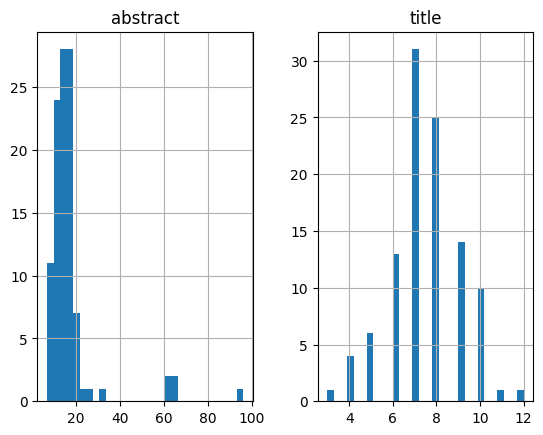

In [34]:
abstract_word_count = []
title_word_count = []

# Convert cleaned_abstract to all strings
cleaned_data['cleaned_abstract'] = cleaned_data['cleaned_abstract'].astype(str)
cleaned_data['cleaned_abstract_pos'] = cleaned_data['cleaned_abstract_pos'].astype(str)

# populate the lists with sentence lengths
for i in cleaned_data['cleaned_abstract']:
  abstract_word_count.append(len(i.split()))

for i in cleaned_data['cleaned_title']:
  title_word_count.append(len(i.split()))

length_df = pd.DataFrame({'abstract':abstract_word_count, 'title':title_word_count})

length_df.hist(bins = 30)
plt.show()

### Split Training and Testing Set

In [35]:
# split the dataset into training and testing sets
abs_tr, abs_te, ttl_tr, ttl_te = train_test_split(
  np.array(cleaned_data[MODEL_CONDITION]),
  np.array(cleaned_data['cleaned_title']),
  test_size=0.1,
  shuffle=True)

### Tokenize Title and Abstracts

In [36]:
# Function to tokenize the datasets
def tokenize_text(train_set, test_set, string_length, rare_word_threshold):
  # find the number of rarewords
  tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_{|}~\t\n') # filters prevent NER tag to be separated
  tokenizer.fit_on_texts(list(train_set))
  rare_word_count = 0
  total_word_count = 0
  for _,freq in tokenizer.word_counts.items():
    total_word_count = total_word_count + 1
    if (freq < rare_word_threshold):
      rare_word_count += 1
    
  # prepare a tokenizer for reviews on training data
  tokenizer = Tokenizer(num_words=total_word_count-rare_word_count, filters='!"#$%&()*+,-./:;=?@[\\]^_{|}~\t\n') # filters prevent NER tag to be separated
  tokenizer.fit_on_texts(list(train_set))

  # convert text sequences into integer sequences
  train_set = tokenizer.texts_to_sequences(train_set) 
  test_set = tokenizer.texts_to_sequences(test_set)

  # padding zero up to maximum length
  train_set = pad_sequences(train_set, maxlen=string_length, padding='post') 
  test_set = pad_sequences(test_set, maxlen=string_length, padding='post')

  # get vector size
  vocab_size = tokenizer.num_words+1

  return tokenizer, train_set, test_set, vocab_size

abs_tokenizer, abs_tr, abs_te, abs_size = tokenize_text(abs_tr, abs_te, MAX_ABSTRACT_LEN, 3)
ttl_tokenizer, ttl_tr, ttl_te, ttl_size = tokenize_text(ttl_tr, ttl_te, MAX_TITLE_LEN, 6)

### Remove Empty Texts

In [37]:
# Function for removing strings with no text
def remove_empty_text(abstract, title):
  indices = []
  for i in range(len(ttl_tr)):
    cnt = 0
    for j in ttl_tr[i]:
      if j!=0:
        cnt=cnt+1
    if (cnt == 2):
      indices.append(i)

  abstract = np.delete(abs_tr, indices, axis=0)
  title = np.delete(ttl_tr, indices, axis=0)
  print(f"removed {len(indices)} empty texts.")

  return abstract, title

abs_tr, ttl_tr = remove_empty_text(abs_tr, ttl_tr)
abs_te, ttl_te = remove_empty_text(abs_te, ttl_te)

removed 72 empty texts.
removed 0 empty texts.


## Build LSTM Model

In [38]:
tf.keras.backend.clear_session() 

# input layer
encoder_inputs = tf.keras.layers.Input(shape=(MAX_ABSTRACT_LEN,))

# embedding layer
enc_emb =  tf.keras.layers.Embedding(abs_size, 
                                     EMBEDDING_DIMENSION, 
                                     trainable=True)(encoder_inputs)

# encoder lstm 1
encoder_lstm1 = tf.keras.layers.LSTM(LATENT_DIMENSION, 
                                     return_sequences=True, 
                                     return_state=True, 
                                     dropout=0.4, 
                                     recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder lstm 2
encoder_lstm2 = tf.keras.layers.LSTM(LATENT_DIMENSION,
                                     return_sequences=True,
                                     return_state=True,
                                     dropout=0.4,
                                     recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder lstm 3
encoder_lstm3 = tf.keras.layers.LSTM(LATENT_DIMENSION, 
                                     return_state=True, 
                                     return_sequences=True,
                                     dropout=0.4,
                                     recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# set up the decoder, using `encoder_states` as initial state.
decoder_inputs = tf.keras.layers.Input(shape=(None,))

# embedding layer
dec_emb_layer = tf.keras.layers.Embedding(ttl_size, 
                                          EMBEDDING_DIMENSION, 
                                          trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder lstm
decoder_lstm = tf.keras.layers.LSTM(LATENT_DIMENSION, 
                                    return_sequences=True, 
                                    return_state=True,
                                    dropout=0.4,
                                    recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,
                                                                     initial_state=[state_h, state_c])

# attention layer
attn_layer = tf.keras.layers.AdditiveAttention()
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# concat attention input and decoder LSTM output
decoder_concat_input = tf.keras.layers.Concatenate()([decoder_outputs, attn_out])

# dense layer
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(ttl_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# define the model 
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      9600        ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

### Train the Model

In [39]:
# initialize model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# train model
history = model.fit([abs_tr, ttl_tr[:,:-1]], ttl_tr.reshape(ttl_tr.shape[0], ttl_tr.shape[1], 1)[:,1:],
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=([abs_te,ttl_te[:,:-1]], ttl_te.reshape(ttl_te.shape[0], ttl_te.shape[1], 1)[:,1:]))

Epoch 1/2


2022-12-16 16:09:30.716753: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-16 16:09:34.806839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2.0851

2022-12-16 16:09:49.007699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 19s 19s/step - loss: 2.0851 - val_loss: 1.7587
Epoch 2/2
1/1 [==============================] - 8s 8s/step - loss: 1.6976 - val_loss: 1.3839


### Inspect Training Validation Loss

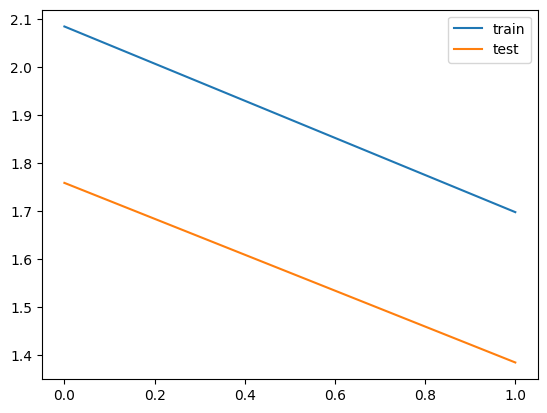

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Vec2Word Dictionary

In [41]:
# grab the dictionaries to convert token ids back to string texts
reverse_target_word_index = ttl_tokenizer.index_word 
reverse_source_word_index = abs_tokenizer.index_word 
target_word_index = ttl_tokenizer.word_index

## Build Inference Model

In [42]:
# encode the input sequence to get the feature vector
encoder_model = tf.keras.models.Model(inputs=encoder_inputs,
                                      outputs=[encoder_outputs, state_h, state_c])

# decoder setup
# below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.layers.Input(shape=(LATENT_DIMENSION,))
decoder_state_input_c = tf.keras.layers.Input(shape=(LATENT_DIMENSION,))
decoder_hidden_state_input = tf.keras.layers.Input(shape=(MAX_ABSTRACT_LEN, LATENT_DIMENSION))

# get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# to predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = tf.keras.layers.Concatenate()([decoder_outputs2, attn_out_inf])

# a dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# final decoder model
decoder_model = tf.keras.models.Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
                                      [decoder_outputs2] + [state_h2, state_c2])

### Decode Inference Output Function

In [51]:
# Function to decode the output of the decoder model
def decode_sequence(input_seq):
  # encode the input as state vectors.
  e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

  # generate empty target sequence of length 1.
  target_seq = np.zeros((1,1))

  # populate the first word of target sequence with the start word.
  target_seq[0, 0] = target_word_index['sostok']

  # loop through the decoder model's outputs and build the output sentence
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
        
    # grab decoder model output tokens and internal states
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)
        
    # convert token back to associated string text
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word_index[sampled_token_index]

    # remove NER tag if necessary
    sampled_token = re.sub('<[^>]+>', '', sampled_token)

    # if the token is not the end token, then add token to the output sentence
    if (sampled_token != 'eostok'):
      decoded_sentence += ' ' + sampled_token

    # exit condition: either hit max length or find stop word.
    if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (MAX_TITLE_LEN-1)):
      stop_condition = True

    # update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # update internal states
    e_h, e_c = h, c

  return decoded_sentence

### Seq2Abstract and Seq2Title Function

In [52]:
# Convert the abstract token id sequence back to string representation
def seq2abstract(input_seq):
  newString = ''
  for i in input_seq:
    if (i != 0):
      newString = newString + reverse_source_word_index[i] + ' '
  return newString

# Convert the title token id sequence back to string representation
def seq2title(input_seq):
  newString = ''
  for i in input_seq:
    if (i != 0 and i != target_word_index['sostok']) and (i != target_word_index['eostok']):
      newString = newString + re.sub('<[^>]+>', '', reverse_target_word_index[i]) + ' '
  return newString

## Testing Model
### BLEU and ROUGE Evaluation Function

In [53]:
rouge_metric = Rouge()

# Evaluation Metric Function; F1 Score with ROUGE and BLEU
def evaluate_title(predicted_ttl, original_ttl):
  # Note: prediction and original titles both need to be string sentences
  f1_score = 0.0
  # get BLEU score
  bleu_result = (sentence_bleu(hypothesis=predicted_ttl, references=[original_ttl], smooth_method='exp'))
  bleu_score = bleu_result.score/100 # sacreBLEU gives the score in percent

  # get ROUGE scores
  rouge_result = rouge_metric.get_scores(hyps=predicted_ttl, refs=original_ttl)
  rouge_l_score = rouge_result[0]["rouge-l"]["f"]
  rouge_1_score = rouge_result[0]["rouge-1"]["f"]
  rouge_2_score = rouge_result[0]["rouge-2"]["f"]

  # check if bleu or rouge-l score are 0
  if (bleu_score == 0.0) or (rouge_l_score == 0.0):
    # if so, f1 score is 0
    f1_score = 0.0
  else:
    f1_score = (2.0 * bleu_score * rouge_l_score) / (bleu_score + rouge_l_score)

  # get scores
  return (f1_score, bleu_score, rouge_l_score, rouge_1_score, rouge_2_score)

### Print Predictions

In [ ]:
# Keep track of total F1 score to average at the end
total_f1 = 0.0
total_bleu = 0.0
total_rouge_l = 0.0
total_rouge_1 = 0.0
total_rouge_2 = 0.0

# results_df = pd.DataFrame()
# results_df['original_abstract'] = abs_te.tolist()
# results_df['original_title'] = ttl_te.tolist()
# results_df['original_title'] = results_df['original_title'].apply(lambda row: seq2title(row))
# results_df['predicted_title'] = results_df['original_abstract'].apply(lambda row: decode_sequence(np.array(row).reshape(1, MAX_ABSTRACT_LEN)))
# results_df['f1_scores'] = results_df.apply(lambda row: evaluate_title(row['predicted_title'], row['original_title']), axis=1)

# Loop over all test set data and calculate F1 score for each prediction
# for i in range(len(abs_te)):
for i in range(5):
  if i % 10 == 0: print(f"i = {i}")

  original_title = seq2title(ttl_te[i])

  prediction_title = decode_sequence(abs_te[i].reshape(1, MAX_ABSTRACT_LEN))
  # print("Abstract:", seq2abstract(abs_te[i]))
  # print("Original Title:", original_title)
  # print("Predicted Title:", prediction_title)

  # Skip bad predictions
  if prediction_title == "" or prediction_title == None: 
    print("Skipping bad prediction...")
    continue

  # Generate F1 score for current prediction
  f1_score, bleu_score, rouge_l_score, rouge_1_score, rouge_2_score = evaluate_title(prediction_title, original_title)

  # Add to total F1
  total_f1 += f1_score
  total_bleu += bleu_score
  total_rouge_l += rouge_l_score
  total_rouge_1 += rouge_1_score
  total_rouge_2 += rouge_2_score

#   if i <= 10:
#     print("Abstract:", seq2abstract(abs_te[i]))
#     print("Original Title:", original_title)
#     print("Predicted Title:", prediction_title)
#     print("F1 Score:", f1_score)
#     print("\n")

# results_df.to_csv("outputs/results.csv")
avg_f1 = total_f1
avg_bleu = total_bleu
avg_rouge_l = total_rouge_l
avg_rouge_1 = total_rouge_1
avg_rouge_2 = total_rouge_2

print("Avg F1 Score:", avg_f1)
print("Avg BLEU Score:", avg_bleu)
print("Avg ROUGE-L Score:", avg_rouge_l)
print("Avg ROUGE-1 Score:", avg_rouge_1)
print("Avg ROUGE-2 Score:", avg_rouge_2)

In [ ]:
cleaned_data.to_csv("output/cleaned_data.csv")